# Likelihood
This document explains the likelihood function for our data, as a function of a phase shift applied to the source signal.

In [176]:
import matplotlib.pyplot as plt
import numpy as np
#from scipy.fftpack import *
import scipy.optimize
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

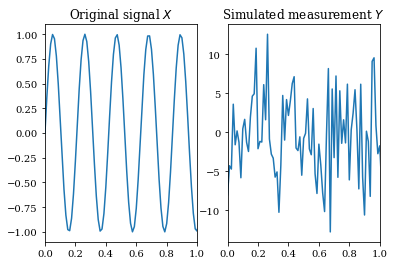

In [226]:
sampleFreq = 80
Tmax = 2

N = int(Tmax*sampleFreq)
T = np.array([float(i)/sampleFreq for i in range(N)])


dataFreq = 4.77
Xfunc = lambda t:np.sin(t*2.0*np.pi * dataFreq)
X = Xfunc(T)

plt.subplot(1,2,1)
plt.title("Original signal $X$")
plt.xlim(0,1)
plt.plot(T,X)


## Let's simulate a measurement by delaying the signal, adding noise and superimposing a second sinusoid.
# Signal delay in seconds
delay = .5 / dataFreq #must be <1
noiseSTD = 5

delayIndex = int(delay*sampleFreq)

#Y = np.interp(T[:N-delayIndex] + delay, T, X)
Y = Xfunc(T[:N-delayIndex] + delay)
noise = np.random.normal(size=Y.shape, loc=0, scale=noiseSTD)
Y+= noise
Y+= + np.sin(T[:N-delayIndex]*2.0*np.pi * 2)

plt.subplot(1,2,2)
plt.title("Simulated measurement $Y$")
plt.xlim(0,1)
plt.plot(T[:N-delayIndex],Y)

plt.show()

# Method 1
## Correlation method

We are trying to find a shift of measurement data that maximizes the _correlation_ between the original signal and the shifted measurement.

We define the _correlation_ between two functions as:
$$
(f \star g)(\tau) = \int f(t)g(t-\tau)dt
$$

... (discretization)

The _correlation window_ ($M$) is the number of data points of $X$, minus the number of data points contained in one full period. Of the original $\texttt{len}(Y)=N-\texttt{delayIndex}$ data points, we have $M$ data points that can be compared to _any_ shifted version of $X$.

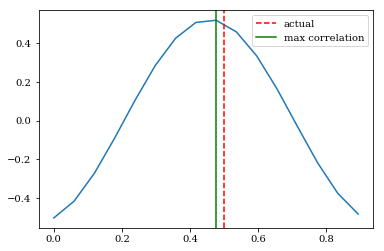

Max correlation at: 0.477


In [227]:
maxShift = min(N,int(sampleFreq / dataFreq))

correlationWindow = N - maxShift

# This should be done with linear interpolation, and scipy.optimize
shiftIndices = list(range(maxShift))
shiftTimes = np.array(shiftIndices)/sampleFreq

correlation = np.zeros(maxShift)
for shift in shiftIndices:
    correlation[shift] = np.dot(X[shift:correlationWindow + shift], Y[:correlationWindow]) / correlationWindow


# The optimal shift is the one with the highest correlation:
optimalShift = shiftTimes[np.argmax(correlation)]



plt.plot(shiftTimes*dataFreq,correlation)
plt.axvline(x=delay*dataFreq, color='r',linestyle="dashed",label="actual")
plt.axvline(x=optimalShift*dataFreq, color='g',label="max correlation")
plt.legend()
plt.show()

print("Max correlation at:",optimalShift*dataFreq)



If the amount of noise is low, this method gives us a decent estimate for the original phase shift. However, it does not provide us with a likelihood function for the shift, or even an error margin.

## Method 2
If we model the noise as a normal distribution, independent for each measurement point, we have:

$Y(t) \sim N(X(t+T_D), \sigma^2)$

where $T_D$ is the delay parameter (in seconds), to be learned from data.

...  (likelihood derivation)

Since the time domain is discretized, we get:

$\log L(D) = -M \log (\sqrt{2 \pi \sigma^2}) - \frac{1}{2 \sigma^2} \sum_{i=0}^{M-1} (Y_i - X_{i+D})^2$

where $D$ is the shift _index_, and non-integer values of $i+D$ correspond to linear interpolation. $M$ is the correlation window.

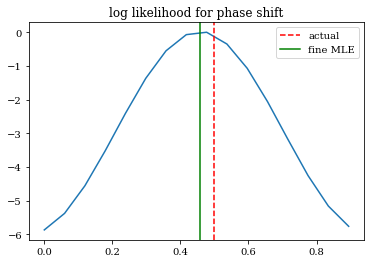

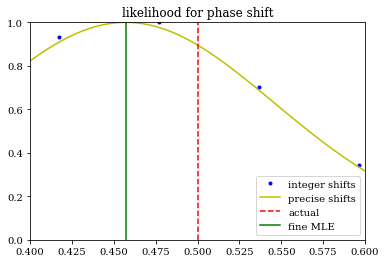

coarse MLE for phase shift:  0.477
fine MLE for phase shift:  0.45713367285783574


In [228]:
noiseVar = noiseSTD**2
M = correlationWindow

def logLikelihood(T_D,precise=True):
    if precise:
        #diffs = Y[:M] - np.interp(T[:M] + T_D, T, X)
        diffs = Y[:M] - Xfunc(T[:M] + T_D)
    else:
        D = int(T_D * sampleFreq)
        diffs = Y[:M]-X[D:M + D]
    return -M*np.log(np.sqrt(2.0*np.pi*noiseVar)) - np.dot(diffs,diffs) / (2.0 * noiseVar)
    return -np.dot(diffs,diffs) / (2.0 * noiseVar)
"""
# The correlation window should be as large as possible

def logLikelihood(T_D,interpolate=True):
    M = len(Y)-int(T_D * sampleFreq)-1
    if interpolate:
        diffs = Y[:M] - np.interp(T[:M] + T_D, T, X)
    else:
        D = int(T_D * sampleFreq)
        diffs = Y[:M]-X[D:M + D]
    return -???M*np.log(np.sqrt(2.0*np.pi*noiseVar)) - np.dot(diffs,diffs) / (2.0 * noiseVar)
    return -np.dot(diffs,diffs) / (2.0 * noiseVar)


"""
# Compute the log likelihood function for poissible shift times, given our data:
dataLogLikelihood = np.vectorize(lambda d: logLikelihood(d,False))(shiftTimes)
# Since the likelihood function is not normalized, we can translate the array to avoid taking the exp of extremely low floating point numbers.
dataLogLikelihood -= np.max(dataLogLikelihood)
dataLikelihood = np.exp(dataLogLikelihood)

# A coarse estimate
MLEcoarse = shiftTimes[np.argmax(dataLikelihood)]
# A finer estimate
MLE = scipy.optimize.minimize(lambda d: -logLikelihood(d[0]), [MLEcoarse], bounds=((0,1.0 / dataFreq),)).x[0]


plotwidth = .2 * 1.0 / dataFreq


plt.title("log likelihood for phase shift")
#plt.xlim(delay*dataFreq - .1, delay*dataFreq + .1)
plt.plot(shiftTimes*dataFreq, dataLogLikelihood,'-')
plt.axvline(x=delay*dataFreq, color='r',linestyle="dashed",label="actual")
plt.axvline(x=MLE*dataFreq, color='g',label="fine MLE")
plt.legend()
plt.show()

shiftTimesPrecise = np.linspace(delay - .1/dataFreq, delay + .1/dataFreq, num=100)
#shiftTimesPrecise = shiftTimes + .013
dataLogLikelihoodPrecise = np.vectorize(lambda d: logLikelihood(d,True))(shiftTimesPrecise)
dataLogLikelihoodPrecise -= np.max(dataLogLikelihoodPrecise)
dataLikelihoodPrecise = np.exp(dataLogLikelihoodPrecise)

plt.title("likelihood for phase shift")
plt.xlim(delay*dataFreq - .1, delay*dataFreq + .1)
plt.ylim(0,1)
plt.plot(shiftTimes*dataFreq, dataLikelihood,'b.',label="integer shifts")
plt.plot(shiftTimesPrecise*dataFreq, dataLikelihoodPrecise,'y-',label="precise shifts")
plt.axvline(x=delay*dataFreq, color='r',linestyle="dashed",label="actual")
plt.axvline(x=MLE*dataFreq, color='g',label="fine MLE")
plt.legend()
plt.show()

print("coarse MLE for phase shift: ",MLEcoarse*dataFreq)
print("fine MLE for phase shift: ",MLE*dataFreq)


# Discussion
- Phase shifts close to $0$ do not give accurate results.
- In the likelihood plot, the graphs for integer shifts and precise shift are not scaled by the same factor.
- Method 2 handles a superimposed second signal well, but the result is overly optimistic. For a superposition of $N$ different sinusoid waves, a single likelihood function (as a function of $N$ phase shifts) might give better results, rather than analyzing band-passed signals.
- The assumption that the noise of each measurement point is independently distributed, is probably incorrect.